<a href="https://colab.research.google.com/github/WOLVS/AditoryAttention/blob/main/tuftdata30s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive/tuftdataset/size_30sec_150ts_stride_03ts'
print("Files in folder:", os.listdir(folder_path))  # list first 5 files


Files in folder: ['sub_23.csv', 'sub_15.csv', 'sub_22.csv', 'sub_13.csv', 'sub_14.csv', 'sub_1.csv', 'sub_20.csv', 'sub_21.csv', 'sub_24.csv', 'sub_25.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_31.csv', 'sub_32.csv', 'sub_34.csv', 'sub_35.csv', 'sub_36.csv', 'sub_37.csv', 'sub_38.csv', 'sub_40.csv', 'sub_42.csv', 'sub_43.csv', 'sub_44.csv', 'sub_45.csv', 'sub_46.csv', 'sub_47.csv', 'sub_48.csv', 'sub_49.csv', 'sub_5.csv', 'sub_51.csv', 'sub_52.csv', 'sub_54.csv', 'sub_55.csv', 'sub_56.csv', 'sub_57.csv', 'sub_58.csv', 'sub_60.csv', 'sub_61.csv', 'sub_62.csv', 'sub_63.csv', 'sub_64.csv', 'sub_65.csv', 'sub_68.csv', 'sub_69.csv', 'sub_7.csv', 'sub_70.csv', 'sub_71.csv', 'sub_72.csv', 'sub_73.csv', 'sub_74.csv', 'sub_75.csv', 'sub_76.csv', 'sub_78.csv', 'sub_79.csv', 'sub_80.csv', 'sub_81.csv', 'sub_82.csv', 'sub_83.csv', 'sub_84.csv', 'sub_85.csv', 'sub_86.csv', 'sub_91.csv', 'sub_92.csv', 'sub_93.csv', 'sub_94.csv', 'sub_95.csv', 'sub_97.csv']


In [ ]:
import os

folder_path = '/content/drive/MyDrive/tuftdataset/size_30sec_150ts_stride_03ts'

# Get all CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Print the number of files
print(f"Number of CSV files: {len(csv_files)}")

Number of CSV files: 68


In [ ]:
import pandas as pd

all_dfs = []
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder_path, file))
        df['subject'] = file.replace('.csv', '')
  # keep subject/file info
        all_dfs.append(df)

df_all = pd.concat(all_dfs, ignore_index=True)
print("Shape:", df_all.shape)


Shape: (15177600, 11)


In [ ]:
print(df_all['label'].value_counts())


label
0    3794400
1    3794400
2    3794400
3    3794400
Name: count, dtype: int64


In [ ]:
df_all['label_binary'] = df_all['label'].map(lambda x: 0 if x in [0, 1] else 1)




In [ ]:
print(df_all['label'].unique())


[0 1 2 3]


In [ ]:
import tsai, fastai
print("tsai:", tsai.__version__)
print("fastai:", fastai.__version__)


tsai: 0.4.1
fastai: 2.8.3


In [ ]:
print(df_all['label_binary'].value_counts())


label_binary
0    7588800
1    7588800
Name: count, dtype: int64


In [ ]:
print(df_all.groupby('label')['label_binary'].unique())


label
0    [0]
1    [0]
2    [1]
3    [1]
Name: label_binary, dtype: object


In [ ]:
# Step 1: Rebuild windows from df_all
import numpy as np
grouped = df_all.groupby(['subject', 'chunk'])

X = []
y = []

for (subj, chunk_id), group in grouped:
    group = group.sort_index()
    if group.shape[0] == 150:
        X.append(group.iloc[:, :8].values)
        y.append(group["label_binary"].iloc[0])

X = np.stack(X)
y = np.array(y).astype(np.int64)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))


X shape: (101184, 150, 8)
y shape: (101184,)
Unique labels: [0 1]


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Random split across all samples (no subject info involved)
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)
splits = (list(train_idx), list(val_idx))

X_train, X_val = X[splits[0]], X[splits[1]]
y_train, y_val = y[splits[0]], y[splits[1]]

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Train labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)


In [ ]:
# X currently: (N, 150, 8)  -> (N, seq_len, n_vars)
X = np.transpose(X, (0, 2, 1))  # -> (N, n_vars=8, seq_len=150)

In [ ]:
print(np.unique(y))

print("X shape:", X.shape)
print(np.unique(y))
print("y shape:", y.shape)



[0 1]
X shape: (101184, 8, 150)
[0 1]
y shape: (101184,)


In [ ]:
print("y dtype:", y.dtype)
print("Unique labels:", np.unique(y))
print("Any NaNs in y:", np.isnan(y).any())
print("Min label:", np.min(y), "Max label:", np.max(y))
print("y[:10]:", y[:10])


In [ ]:
from tsai.all import *
from fastai.callback.all import SaveModelCallback
%env CUDA_LAUNCH_BLOCKING=1


tfms = [None, [Categorize()]]


dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid,
                               bs=[64, 128],
                               batch_tfms=[TSStandardize()],
                               num_workers=0)

print("X shape:", X.shape)
print(np.unique(y))
print("y shape:", y.shape)

In [ ]:
from tsai.all import *

arch = LSTM
arch_config = {'n_layers': 3, 'bidirectional': True}
mv_clf = TSClassifier(X, y, splits=splits,
                      path='models',
                      arch=arch,
                      arch_config=arch_config,
                      tfms=[None, [Categorize()]],
                      batch_tfms=[TSStandardize()],
                      metrics=accuracy,
                      cbs=ShowGraph())

mv_clf.fit_one_cycle(20, 1e-3)

# Save the model
mv_clf.save('LSTM_Tufts_Weights')


In [ ]:
mv_clf.export('LSTM_Tufts_Cclean.pkl')


In [ ]:
print(mv_clf.path)       # Base path
print(mv_clf.model_dir)  # Subfolder where models are stored


In [ ]:
from pathlib import Path
full_path = Path(mv_clf.path) / mv_clf.model_dir / 'LSTM_Tufts_Cclean.pkl'
print(full_path)


In [ ]:
mv_clf.path = Path('/content/drive/MyDrive/models')
mv_clf.export('LSTM_Tufts_Cclean.pkl')


In [ ]:
print(mv_clf.model)


In [ ]:
# Print any LSTM modules (will show hidden_size, num_layers, bidirectional, dropout)
for m in mv_clf.model.modules():
    if isinstance(m, torch.nn.LSTM):
        print(m)

In [ ]:
logits, preds, targs = mv_clf.get_preds(with_input=False, with_decoded=True)


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

acc = accuracy_score(targs, preds)
print(f"Accuracy on Tufts val: {acc:.4f}")
print("\Classification Report:")
print(classification_report(targs, preds))
print("\Confusion Matrix:")
print(confusion_matrix(targs, preds))


In [ ]:
logits_train, targs_train = mv_clf.get_preds(ds_idx=0, with_input=False, with_decoded=False)

from sklearn.metrics import accuracy_score

# Use logits_train instead of preds_train
train_acc = accuracy_score(targs_train, logits_train.argmax(axis=1))
print("Training accuracy: {train_acc:.4f}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds_class = logits_train.argmax(axis=1)

print("\Training Classification Report:")
print(classification_report(targs_train, preds_class))

print("\Training Confusion Matrix:")
print(confusion_matrix(targs_train, preds_class))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(targs, preds)
labels = ["Class 0", "Class 1"]

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Tufts Validation Set")
plt.tight_layout()
plt.show()


In [ ]:
print(dls.vars, dls.len)


In [ ]:
from tsai.all import *

# Create model with the correct architecture as the other one led to errors, so now creating a new model with dummy dataloaders
model = create_model(LSTM, c_in=8, c_out=2, seq_len=150, arch_config={'n_layers': 3, 'bidirectional': True})

def get_dummy_dl(seq_len=150, n_vars=8, n_classes=2):
    X_dummy = np.random.randn(2, n_vars, seq_len).astype(np.float32)  # (2, 8, 150)
    y_dummy = np.array([0, 1])
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X_dummy, y_dummy, tfms=tfms)
    return TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=2)

dls = get_dummy_dl()

# load the weights and learner from the .pth
learn = Learner(
    dls, model, metrics=accuracy,
    path='models/models',  # matches your file's folder
    model_dir='.'          # file is directly inside it
)

#loading and exporting
learn.load('LSTM_Tufts_Weights')  # no .pth extension needed
learn.export("LSTM_Tufts_Ccclean.pkl")  # this is your final clean model



In [ ]:
#checking if it is saved
import os

for root, dirs, files in os.walk("models/models"):
    for file in files:
        if file.endswith(".pkl"):
            print("Found:", os.path.join(root, file))


In [ ]:
from google.colab import files
files.download("/content/models/models/LSTM_Tufts_Ccclean.pkl")


In [ ]:
import os
print(os.path.abspath("models/models/LSTM_Tufts_Clean.pkl"))


In [ ]:
import os

for root, dirs, files in os.walk("models"):
    for file in files:
        if file.endswith(".pth"):
            print("Found:", os.path.join(root, file))


In [ ]:
!pip install tsai==0.4.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import files
files.upload()  # exporting the model trained on my datsset to evaluate on this dataset


Saving LSTM_finalL_clean_export.pkl to LSTM_finalL_clean_export.pkl


{'LSTM_finalL_clean_export.pkl': b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00!\x00A\x00LSTM_finalL_clean_export/data.pklFB=\x00ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ\x80\x02cfastai.learner\nLearner\nq\x00)\x81q\x01}q\x02(X\x03\x00\x00\x00dlsq\x03ctsai.data.core\nTSDataLoaders\nq\x04)\x81q\x05}q\x06(X\x07\x00\x00\x00loadersq\x07]q\x08(ctsai.data.core\nTSDataLoader\nq\t)\x81q\n}q\x0b(X\x07\x00\x00\x00weightsq\x0cNX\t\x00\x00\x00partial_nq\rNX\x07\x00\x00\x00samplerq\x0eNX\x04\x00\x00\x00sortq\x0f\x89X\x08\x00\x00\x00do_setupq\x10\x89X\n\x00\x00\x00after_itemq\x11cfasttransform.transform\nPipeline\nq\x12)\x81q\x13}q\x14(X\t\x00\x00\x00split_idxq\x15NX\x07\x00\x00\x00defaultq\x16NX\x02\x00\x00\x00fsq\x17cfastcore.foundation\nL\nq\x18)\x81q\x19}q\x1aX\x05\x00\x00\x00itemsq\x1b]q\x1csbubX\x0c\x00\x00\x00before_batchq\x1dh\x12)\x81q\x1e}q\x1f(h\x15Nh\x16Nh\x17h\x18)\x81q }q!h\x1b]q"sbubX\x0b\x00\x00\x00after_batchq

In [ ]:
from tsai.all import *
import pathlib, sys

# handling path
if sys.platform == "linux":
    pathlib.WindowsPath = pathlib.PosixPath

#
learn = load_learner("LSTM_finalL_clean_export.pkl")




In [ ]:
from tsai.all import *
from tsai.data.core import TSTensor
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure dtype + type
X = X.astype(np.float32)
Xt = TSTensor(X)

# Get predictions (your loaded learner from the .pkl or weights)
probs, targs = learn.get_X_preds(Xt, y=y, bs=128)[:2]
preds = probs.argmax(1).cpu().numpy()
true_y = y if targs is None else targs.cpu().numpy()

print("Accuracy:", accuracy_score(true_y, preds))
print(classification_report(true_y, preds, digits=3))
print(confusion_matrix(true_y, preds))


Accuracy: 0.44177933270082226
              precision    recall  f1-score   support

           0      0.465     0.770     0.580     50592
           1      0.331     0.114     0.169     50592

    accuracy                          0.442    101184
   macro avg      0.398     0.442     0.374    101184
weighted avg      0.398     0.442     0.374    101184

[[38956 11636]
 [44847  5745]]


In [ ]:
# Confirm the preprocessing matches training
print(learn.dls.after_batch)

# Sanity
import numpy as np
preds = probs.argmax(1).cpu().numpy()
print("Pred class counts:", dict(zip(*np.unique(preds, return_counts=True))))


Pipeline: 
Pred class counts: {np.int64(0): np.int64(83803), np.int64(1): np.int64(17381)}


In [ ]:
print(X.shape)          # should be (N, 8, 150)
print(X.dtype)          # should be float32
print(len(y))           # should equal N


(101184, 8, 150)
float32
101184


In [ ]:
print(type(X))          # should be TSTensor before passing to model


<class 'numpy.ndarray'>


In [ ]:
import numpy as np
print("Class distribution:", np.bincount(y))


Class distribution: [50592 50592]


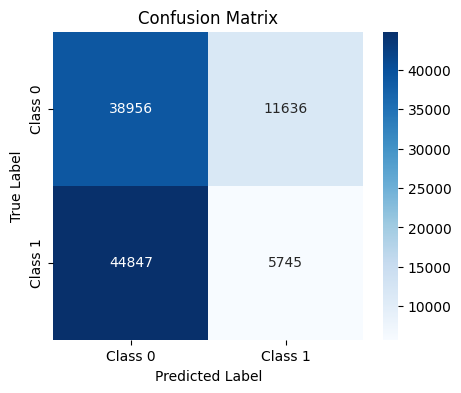

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix
cm = confusion_matrix(true_y, preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
